In [1]:
import xlrd
import os
import numpy as np
import pandas as pd
import numpy as np

def write_all():
    workbook = xlrd.open_workbook("./Closed End Holdings 3.xlsx")
    names = workbook.sheet_names()
    for x in range(0,workbook.nsheets):
        sheet = workbook.sheet_by_index(x)
        df = pd.DataFrame([sheet.row_values(x) for x in range(1, sheet.nrows)])
        df.columns = df.iloc[0]
        df = df[1:]
        name = names[x]
        if name not in ["ead", "Fund Names"]:
            df.to_csv("funds/"+name.upper()+".csv")
write_all()

In [2]:
def create_hf():   
    hf = pd.DataFrame({})
    my_dir = os.listdir("./funds")
    for x in my_dir:
        df = pd.read_csv("./funds/"+x)
        name = x.split(".csv")[0]
        cf = df["ID.WEIGHTS"].to_frame(name)
        cf.index = df.iloc[:,-1].replace(np.nan, "N/A")
        cf = cf.dropna(axis=0)
        na = cf[cf.index=="N/A"].astype('float').sum(axis=0)
        na += cf.iloc[cf.index.str[:4]=="#N/A"].sum(axis=0)
        cf = cf[(cf.index != "N/A") & (cf.index.str[:4]!="#N/A")]
        cf.loc["N/A"] = na
        cf = cf.groupby(level=0).sum()
        hf = hf.merge(cf, how='outer', left_index=True, right_index=True)


    hf = hf.fillna(0)
    hf = hf.astype('float')
    hf = hf.div(hf.sum(), axis=1)*100
    return hf
hf = create_hf()


In [3]:
def create_index():
    sf = pd.read_csv("./s&p500.csv")
    return sf


In [4]:
def create_discount_df():
    df = pd.read_csv("Discount.csv", index_col=0)
    my_dir = os.listdir("./funds")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)].iloc[:,:4]
    df = df.apply(lambda x: [x["Discount"].strip("%"),x["52W Discount"].strip("%"), x["Effective"].strip("%"), x["Distribution"].strip("%")], axis=1, result_type='expand')
    df = df.replace("--",0)
    df.columns = ["Discount", "52W Discount","Effective","Distribution"]
    df = df.astype('float')
    df["Discount_Weights"] = (((df["Discount"]+ (df["Discount"] - df["52W Discount"]))+100)/100)
    discount_df = df.reindex([x.upper() for x in hf.columns])
    return discount_df


In [5]:


def change_down(weights, find, no_change_nums):
    k = [x + (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]-.01)
    for x in no_change_nums:
        k[x] = weights[x]
    return k


def change_up(weights, find, no_change_nums):
    l = weights
    k = [x - (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]+.01)
    for x in no_change_nums:
        k[x] = weights[x]
    negs = abs(sum(list(filter(lambda x: max(x,0)==0, k))))
    zeros = list(filter(lambda x: max(k[x],0)==0, range(len(k))))
    for x in zeros:
        k[x] = 0
    zeros.append(find)
    zeros = zeros + no_change_nums
    not_zeros = list(filter(lambda x: x not in zeros, range(len(k))))
    for x in not_zeros:
        k[x] = k[x] - (negs/len(not_zeros))
    if negs != 0 and not_zeros == []:
        return False
    return k

def find(weights):
    global hf
    global sf
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    w = [max(x,0) for x in weights]
    val = sum(discount_df['Discount_Weights'] * w)
    [max(x,0) for x in weights]
    close_val = (abs(sum(filter(lambda x: x < 0, df["Weight"]-df["ours"])))+100)
    return close_val * val

def best(type, weights, ideal, ideal_weights):
    if weights == False:
        return ideal_weights
    if list(filter(lambda x: x < 0, weights)) != list():
        return ideal_weights
    global no_change_nums
    global find_num
    num = find(weights)
    if num < ideal:
        if type == "up":
            if weights[find_num] + .01 > 0:
                return best("up",  change_up(weights, find_num, no_change_nums), num, weights)
            else:
                return weights
        if type == "down":
            if weights[find_num] - .01 > 0:
                return best("down", change_down(weights, find_num, no_change_nums), num, weights)
            else: 
                return weights
    else:
        return ideal_weights
    
    
def go_through(weights):
    global no_change_num
    global find_num
    num = find(weights)
    dw = change_down(weights, find_num, no_change_nums)
    uw = change_up(weights, find_num, no_change_nums)
    if uw == False and dw == False:
        return weights
    elif uw == False:
        return best("down", dw,num, weights)
    elif dw == False:
        return (best("up", uw,num, weights))
    up = find(uw)
    down = find(dw)
    if up < down and up < num:
        return (best("up", uw,num, weights))
        
    elif down < num:
        return best("down", dw,num, weights)
    else:
        return weights
    
        




In [6]:
def do(way):
    global find_num
    global no_change_nums
    weights = [1/len(hf.columns) for x in range(len(hf.columns))]
    n = 0
    for x in way:
        find_num = x[0]
        no_change_nums = x[1]
        weights = go_through(weights)
        n+=1
    return weights

In [7]:
def path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y+1)
    


def path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y-1)

def weird_path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y-1)
    
def weird_path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y+1)

def way1(): 
    global z
    z = len(hf.columns)-1
    return path(0) + weird_path2(z)
    
def way2():
    global z
    z = len(hf.columns)-1
    return path(0) + path2(z)

def way3():
    global z
    z = len(hf.columns)-1
    return path2(z) + path(0)

def way4(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + weird_path(0)

def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way6(): 
    global z
    z = len(hf.columns)-1
    return path(0) + [7,[]] + path(0)
def way7(): 
    global z
    z = len(hf.columns)-1
    return path2(z)
def way8(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + [0,[]] + path2(z)
paths = [way1,way2,way3,way4]


In [8]:
def create_assets(weights):
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    tf = df[df['Weight']!=0]
    not_in = df[df['Weight']==0]["ours"].sum()
    tf = tf.rename(columns={"Weight":"Index"})
    tf = tf.sort_values(by=['ours'], ascending=False)
    i = pd.DataFrame([[not_in, 0]], ["notINs&p500"], columns=["ours","Index"])
    tf = tf.append(i)
    return tf

def how_much():
    global tf
    tf["more"] = tf["Index"] -tf["ours"]
    amount_more = abs(tf[tf["more"]<0]["more"]).sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    amount_sp500 = (100/(abs(tf[tf["more"]<0]["more"]).sum()+100))
    amount_buy = tf[tf["more"]>0]["more"].sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    return amount_sp500

def avg_discount():
    df = discount_df.reindex(hf.columns,axis=0)
    df["Weights"] = weights
    avg_discount = (df["Discount"]*df["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_effective():
    df2 = discount_df.reindex(hf.columns,axis=0)
    df2["Weights"] = weights
    avg_discount = (df2["Effective"]*df2["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_distribution():
    df2 = discount_df.reindex(hf.columns,axis=0)
    df2["Weights"] = weights
    avg_discount = (discount_df["Distribution"]*weights).sum()
    return avg_discount

In [9]:
how_much_dis = [100, 0, -1, -2, -3,-4,-5,-6,-7,-8,-9,-10]
final = pd.DataFrame(columns=["Weights"])
dicty = []
path_num = 0
hf_orig = create_hf()
sf_orig = create_index()
hf = hf_orig
discount_df_orig = create_discount_df()


global discount_df
global weights

for way in paths:
    path_num += 1
    hf = hf_orig
    sf = sf_orig
    discount_df = discount_df_orig
    print(len(discount_df))
    print("NEXT")
    while True:
        if len(discount_df) == 25:
            break
        
        weights = do(way())

        weights = [round(x,3) for x in weights]
        weights_not_zero = list(filter(lambda x: x > 0,weights))
        print(weights_not_zero)
        if len(weights_not_zero) <= 2:
            print("hey")
            break
            
        tf = create_assets(weights)
        
        amount_sp500 = how_much()
        print(amount_sp500)
        
        average_discount = avg_discount()
        average_effective = avg_effective()
        average_distribution = avg_distribution()
        print(average_discount)
        df = discount_df.reindex(hf.columns,axis=0)
        df["Weights"] = weights

        df["hmd"] = str(path_num)+ "," + str(len(discount_df))
        df.index = pd.MultiIndex.from_frame(df.reset_index()[["hmd","index"]])
        final = pd.concat([final, df[["Weights"]]])
        dicty.append({
            "which": (str(path_num), str(len(discount_df))),
            "x":amount_sp500*100,
            "y": average_discount,
            "effective": average_effective,
            "distribution": average_distribution
        })
        discount_df = discount_df.sort_values(by=["Discount"], ascending=False)
        discount_df = discount_df.iloc[1:]
        hf = hf[discount_df.index]
       

final.index = pd.MultiIndex.from_tuples(final.index)

49
NEXT
[0.02, 0.829, 0.003, 0.013, 0.133]
0.6819168974891654
-9.7869804194681
[0.005, 0.006, 0.005, 0.086, 0.005, 0.002, 0.003, 0.003, 0.004, 0.025, 0.032, 0.001, 0.002, 0.002, 0.003, 0.014, 0.002, 0.003, 0.441, 0.005, 0.003, 0.001, 0.001, 0.032, 0.163, 0.001, 0.095, 0.005, 0.045, 0.007]
0.7134835296733604
-10.184763341028317
[0.001, 0.001, 0.006, 0.006, 0.006, 0.086, 0.006, 0.003, 0.004, 0.004, 0.005, 0.025, 0.033, 0.002, 0.003, 0.003, 0.004, 0.015, 0.003, 0.004, 0.451, 0.006, 0.003, 0.002, 0.002, 0.032, 0.133, 0.003, 0.065, 0.007, 0.057, 0.018]
0.7137145263130679
-9.955282756004145
[0.001, 0.006, 0.006, 0.006, 0.086, 0.006, 0.003, 0.004, 0.004, 0.005, 0.025, 0.033, 0.002, 0.003, 0.003, 0.003, 0.005, 0.003, 0.004, 0.441, 0.005, 0.003, 0.002, 0.001, 0.032, 0.183, 0.002, 0.004, 0.046, 0.001, 0.001, 0.056, 0.017]
0.7141222062433751
-10.037166139302197
[0.005, 0.005, 0.005, 0.085, 0.005, 0.002, 0.003, 0.003, 0.004, 0.024, 0.032, 0.001, 0.001, 0.002, 0.002, 0.013, 0.002, 0.002, 0.45, 0.00

[0.001, 0.002, 0.003, 0.001, 0.002, 0.478, 0.001, 0.035, 0.018, 0.005, 0.226, 0.061, 0.047, 0.12]
0.6854261517048114
-11.616951986430514
[0.001, 0.476, 0.001, 0.01, 0.038, 0.019, 0.211, 0.021, 0.063, 0.002, 0.064, 0.095]
0.6850368550476299
-11.623712206816734
[0.468, 0.001, 0.011, 0.038, 0.029, 0.211, 0.021, 0.063, 0.001, 0.043, 0.115]
0.6835676524024454
-11.613650358080971
[0.013, 0.002, 0.477, 0.001, 0.035, 0.028, 0.21, 0.05, 0.064, 0.117]
0.68777439854973
-11.602657815118148
49
NEXT
[0.011, 0.231, 0.001, 0.001, 0.045, 0.001, 0.092, 0.001, 0.006, 0.004, 0.029, 0.109, 0.039, 0.029, 0.019, 0.03, 0.322, 0.002, 0.004, 0.024]
0.6954191005201461
-10.188884271933885
[0.08, 0.03, 0.03, 0.01, 0.001, 0.441, 0.001, 0.002, 0.001, 0.002, 0.004, 0.037, 0.002, 0.206, 0.003, 0.053, 0.003, 0.028, 0.063]
0.7138446930223553
-10.616562397164884
[0.08, 0.02, 0.04, 0.01, 0.001, 0.441, 0.001, 0.001, 0.001, 0.002, 0.002, 0.039, 0.002, 0.216, 0.003, 0.045, 0.003, 0.003, 0.028, 0.059]
0.7142449490205287
-10.6

In [15]:
final.to_csv("../flask/equities/dataframes/final.csv")

In [10]:
hey = list(dicty)
t = list(dicty)
for y in hey:
    if list(filter(lambda t: t["x"] > y["x"] and t["y"] < y["y"], hey)) != []:
        t.remove(y)

len(t)


28

<IPython.core.display.Javascript object>


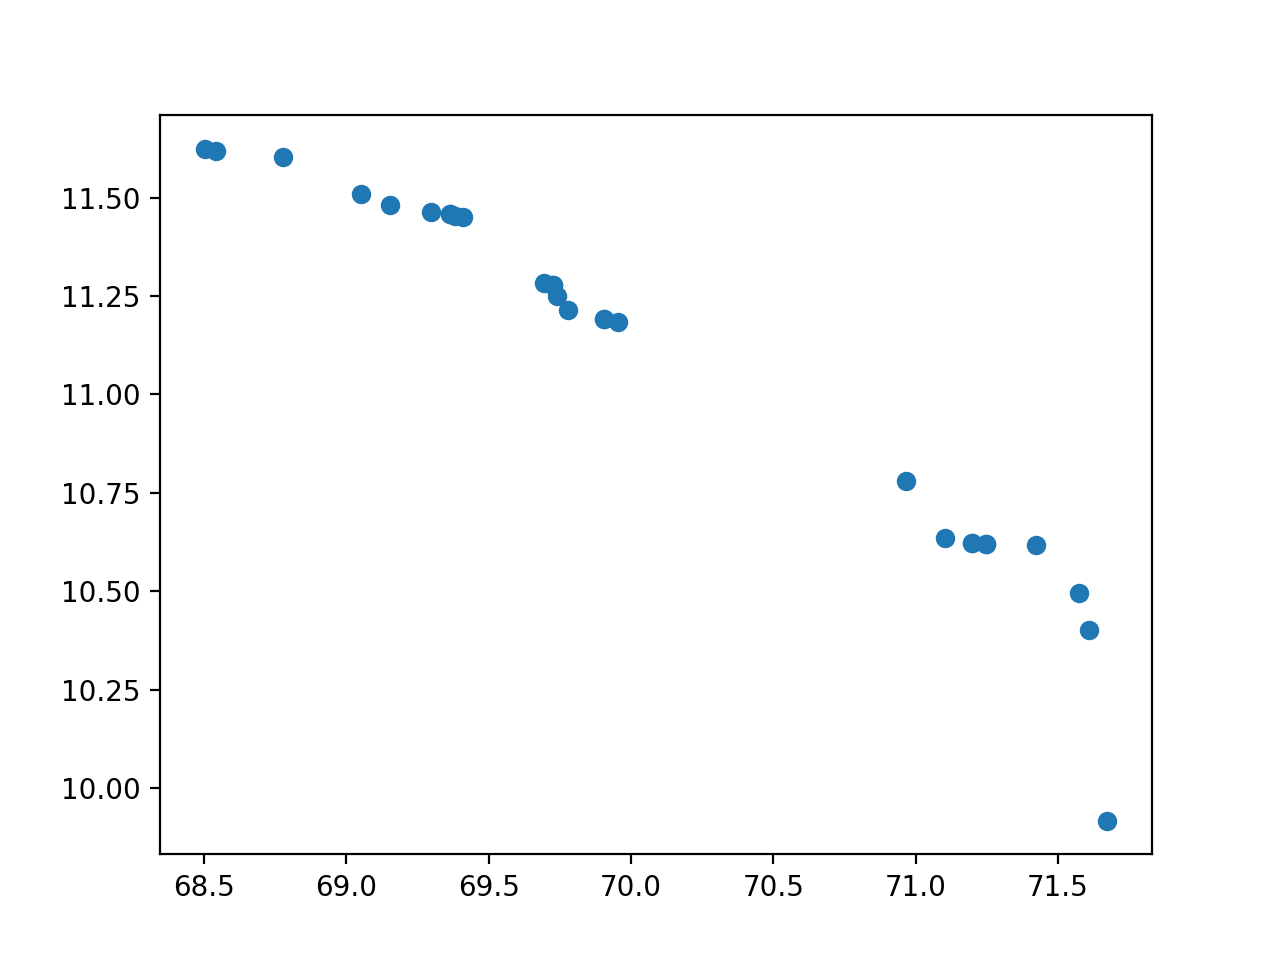

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot([x["x"] for x in t],[abs(x["y"]) for x in t],"o")
plt.show()

In [12]:
import json
with open('../flask/equities/dataframes/dicty.json', 'w') as outfile:
    json.dump(t, outfile)

In [63]:
hf = create_hf()
discount_df = create_discount_df()
discount_df["Distribution"]

Ticker
STK       6.70
ADX      20.55
CHN       0.44
MIE       7.44
SZC       6.89
CII       5.99
GRF       7.54
BCX       6.63
CRF      18.94
CEN      26.87
ASA       0.09
AGD       7.51
AIO       5.05
RFI       7.23
BME       4.93
CPZ       8.17
CEM      10.33
BSTZ      3.83
NFJ       6.77
RNP       6.80
EXD       8.49
EOI       6.67
CTR      10.09
GLQ       9.68
BGR       7.88
JEQ       2.72
DSE     113.21
BDJ       7.19
SRV       6.37
CLM      19.15
EMO       8.92
DPG      12.15
AWP       9.28
EOS       5.50
BIF       3.68
ETJ       8.69
IAF       9.77
AOD       7.84
BGY       6.99
BMEZ      4.07
CET       9.43
UTF       7.21
BOE       7.09
IGR       8.93
PEO      14.84
DNP       7.52
RQI       7.90
AEF       2.64
BUI       6.01
Name: Distribution, dtype: float64

In [64]:
create_discount_df()

,Discount,52W Discount,Effective,Distribution,Discount_Weights
Ticker,,,,,
STK,0.80,2.16,0.00,6.70,0.9944
ADX,-13.27,-13.74,0.00,20.55,0.8720
CHN,-9.55,-13.63,0.10,0.44,0.9453
MIE,-18.24,-12.00,18.02,7.44,0.7552
SZC,-23.32,-21.58,3.02,6.89,0.7494
CII,-7.00,-8.30,0.10,5.99,0.9430
GRF,-22.63,-18.83,0.00,7.54,0.7357
BCX,-14.22,-15.29,1.20,6.63,0.8685
CRF,20.55,9.89,9.50,18.94,1.3121


In [37]:
dicty

[{'which': ('1', '49'),
  'x': 68.12939958256592,
  'y': -9.788479426121434,
  'effective': 0.4414994931500986,
  'distribution': 18.205383700000002}]